In [1]:
import random as rd
import numpy as np
import math as mt
from matplotlib import pyplot as plt
import pandas as pdb

## Functions

### Lattice

In [4]:
def count(lattice, length):
    n_count = 0
    g_count = 0
    s_count = 0
    t_count = 0
    b_count = 0

    for i in range(length):
        for j in range(length):
            if lattice[j][i] == 0:
                s_count += 1
            elif 1 >= lattice[j][i] >= 0.5:
                t_count += 1
            elif 0.5 > lattice[j][i] > 0:
                g_count += 1
            elif lattice[j][i] > 1:
                n_count += 1
            else:
                b_count += 1  # negative numbers

    m_sum = s_count + t_count + g_count + n_count + b_count
    print("Source:", s_count)
    print("Tolerant: ", t_count)
    print("Gullible: ", g_count)
    # print("Neutral: ", n_count)
    # print("b_count", b_count)
    print("TOTAL", m_sum)
    return


def lattice_initialize(lattice, length, coverage):
    counter = 0  # main counter
    gullible_counter = 0
    tolerant_counter = 0
    maximum = length ** 2 - 1

    max_gullible = maximum * coverage
    max_tolerant = maximum - 1 - max_gullible

    while counter < maximum:
        # guess random position
        xs = rd.choice(range(length))
        ys = rd.choice(range(length))
        v = rd.triangular()
        # print(v, counter, tolerant_counter, gullible_counter, xs, ys)

        if lattice[ys][xs] == 10000:
            if v > 0.5 and tolerant_counter < max_tolerant:
                lattice[ys][xs] = v
                tolerant_counter += 1
                counter += 1
            elif v < 0.5 and gullible_counter < max_gullible:
                lattice[ys][xs] = v
                gullible_counter += 1
                counter += 1

    count(lattice, length)
    np.savetxt("Initial Population " + str(coverage) + ".csv", lattice, delimiter = ",")  # Save init Population to csv
    return lattice


def gullible_counter(lattice, length):
    counter = 0
    for i in range(length):
        for j in range(length):
            if lattice[j][i] < 0.5 and lattice[j][i] != 0:
                counter += 1
    return counter


def count_source(lattice, length):
    counter = 0
    for i in range(length):
        for j in range(length):
            if lattice[j][i] == 0:
                counter += 1
    return counter


def tolerant_counter(lattice, length):
    counter = 0
    for i in range(length):
        for j in range(length):
            if 0.5 <= lattice[j][i] < 1:
                counter += 1
    return counter


### Lattice Update

In [5]:
def main_equation(value, x, y, i, j, multiplier):
    alpha = rd.triangular()
    out = value + multiplier * (-alpha * (1/(mt.sqrt(((x - i)**2 + (y - j)**2)))))
    return out


def update_lattice_equation(lattice, length, initial_n, time, decay_constant):
    for i in range(length):
        for j in range(length):
            if lattice[j][i] == 0:

                multi = initial_n * (mt.exp(-time / decay_constant))
                
                try:  # below the source
                    lattice[j+1][i] = main_equation(lattice[j + 1][i], i, j, i, j+1, multi)
                    # print("1")
                except IndexError:
                    pass

                try:  # above the source
                    lattice[j-1][i] = main_equation(lattice[j + 1][i], i, j, i, j-1, multi)
                    # print("2")
                except IndexError:
                    pass

                try:  # right to the source
                    lattice[j][i+1] = main_equation(lattice[j + 1][i], i, j, i + 1, j, multi)
                    # print("3")
                except IndexError:
                    pass

                try:  # left to the source
                    lattice[j][i-1] = main_equation(lattice[j + 1][i], i, j, i - 1, j, multi)
                    # print("4")
                except IndexError:
                    pass

                try:  # diagonal down and right
                    lattice[j+1][i + 1] = main_equation(lattice[j + 1][i], i, j, i+1, j+1, multi)
                    # print(5)
                except IndexError:
                    pass

                try:  # diagonal down and left
                    lattice[j+1][i-1] = main_equation(lattice[j + 1][i], i, j, i-1, j+1, multi)
                    # print("6")
                except IndexError:
                    pass

                try:  # diagonal up and right
                    lattice[j-1][i+1] = main_equation(lattice[j + 1][i], i, j, i+1, j-1, multi)
                    # print("7")
                except IndexError:
                    pass

                try:  # diagonal up and left
                    lattice[j-1][i-1] = main_equation(lattice[j + 1][i], i, j, i-1, j-1, multi)
                    # print("9")
                except IndexError:
                    pass

    for i in range(length):
        for j in range(length):
            if lattice[j][i] < 0:
                lattice[j][i] = 0

    return lattice


def update_matrix_equation(lattice, decay_constant, initial_n, length, time, x0, y0):  # Equation Based Approach
    multiplier = initial_n * (mt.exp(-time / decay_constant))

    for i in range(length):
        for j in range(length):
            if i != x0 and j != y0:
                alpha = rd.triangular()
                lattice[j][i] = lattice[j][i] + multiplier * (-alpha * 1 / (mt.sqrt(((x0 - i) ** 2 + (y0 - j) ** 2))))

    for i in range(length):
        for j in range(length):
            if lattice[j][i] < 0:
                lattice[j][i] = 0

    return lattice


In [2]:
decay_const: int = 1
n_0 = 1
repeat = 1500

In [6]:
main_source = {}
main_gullible = {}
main_tolerant = {}
main_step = []

for i in range(repeat):
    source50 = []
    gullible50 = []
    tolerant50 = []
    
    check = True
    step = 0
    n = 100    # length of the matrix
    N = np.full(shape=(n, n), fill_value=10000, dtype=np.float32)  # creates matrix will all values having 10000
    tm = 0  # time

    source_counter = 0
    max_source = (n**2) * 0.9  # stopping criteria

    xs = 50
    ys = 50

    # xs = rd.choice(range(n))  # initial x and y for the source, (value == 0)
    # ys = rd.choice(range(n))

    N[ys][xs] = 0
    
    lattice_initialize(N, n, 0.50)

    while check == True:
        print('Step Number: ', tm)
        update_lattice_equation(N, n, n_0, 1, decay_const)
        source50.append(count_source(N, n))
        tolerant50.append(tolerant_counter(N, n))
        gullible50.append(gullible_counter(N, n))
        tm += 1

        if tm > 200:
            if source50[tm-1] == source50[tm-2] and source50[tm-2] == source50[tm-3] and source50[tm-3] == source50[tm-4] and source50[tm-4] == source50[tm-5] and source50[tm-5] == source50[tm-6]:
                check = False

    np.savetxt("Final_Population_50_" + str(i) + ".csv", N, delimiter = ",")
    
    main_source[str(i)] = source50
    main_gullible[str(i)] = gullible50
    main_tolerant[str(i)] = tolerant50
    
    print('END------------------------------------------END')

Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step

Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  

Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  

Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step

Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Ste

Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Numbe

Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Numbe

Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Numbe

Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Ste

Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step 

Step Number:  238
Step Number:  239
Step Number:  240
Step Number:  241
Step Number:  242
Step Number:  243
Step Number:  244
Step Number:  245
Step Number:  246
Step Number:  247
Step Number:  248
Step Number:  249
Step Number:  250
Step Number:  251
Step Number:  252
Step Number:  253
Step Number:  254
Step Number:  255
Step Number:  256
Step Number:  257
Step Number:  258
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
St

Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45

Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Numb

Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  

Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  

Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
S

Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Num

Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  

Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Numbe

Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
END------------------------------------------E

Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Numbe

Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
END------------------------------------------E

Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  

Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Number:  234
Step Number:  235
Step Number:  236
Step Number:  237
Step Number:  238
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Nu

Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step

Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
S

Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number

Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27

Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28


Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step

Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Numb

Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  

Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  

Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  

Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  11

Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Numbe

Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step

Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Numbe

Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Numbe

Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27

Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
S

Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Number:  234
Step Number:  235
Step Number:  236
Step Number:  237
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  4

Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  

Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  

Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  

Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number

Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Numbe

Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Numbe

Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Numbe

Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Number:  234
Step Number:  235
Step Number:  236
Step Number:  237
Step Number:  238
Step Number:  239
Step Number:  240
Step Numbe

Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
END------------------------------------------E

Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step

Step Number:  221
Step Number:  222
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step

Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step

Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Numb

Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Numbe

Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Ste

Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step 

Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Numbe

Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Numbe

Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Numbe

Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Numbe

Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Numbe

Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Nu

Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number

Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step

Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Numbe

Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step N

Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  1

Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Numbe

Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Numbe

Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
END-------------------------

Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Nu

Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
St

Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  4

Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:

Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number: 

Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
S

Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step

Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Num

Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  

Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:

Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step N

Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  1

Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Numbe

Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Numbe

Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
St

Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Num

Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Numb

Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
S

Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  

Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step

Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Number:  234
Step Number:  235
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step 

Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Numbe

Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Numbe

Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number: 

Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Number:  234
Step Number:  235
Step Number:  236
Step Number:  237
Step Number:  238
Step Number:  239
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number

Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
S

Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  

Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:

Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Numbe

Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
St

Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Numb

Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:

Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Numb

Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  

END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step N

Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  

Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
St

Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step

Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Numbe

Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Numbe

Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Numbe

Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
S

Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  

Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  

Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  

Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:

Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  1

Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Numbe

Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Numbe

Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Numbe

Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
END-------

Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Numb

Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step

Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number: 

Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  

Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130


Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step

Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  1

Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Nu

Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Numbe

Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Numbe

Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Numbe

Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Numbe

Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
S

Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  6

Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  

Step Number:  236
Step Number:  237
Step Number:  238
Step Number:  239
Step Number:  240
Step Number:  241
Step Number:  242
Step Number:  243
Step Number:  244
Step Number:  245
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number: 

Step Number:  246
Step Number:  247
Step Number:  248
Step Number:  249
Step Number:  250
Step Number:  251
Step Number:  252
Step Number:  253
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  4

Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  4

Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  

Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  

Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  

Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  

Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  11

Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  

Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Nu

Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Numbe

Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullibl

Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Numbe

Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Nu

Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46


Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  

Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step

Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  

Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step

Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113


Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:

Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Nu

Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Numbe

Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Numbe

Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Numbe

Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Numbe

Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Numbe

Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Numbe

Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Numbe

Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Numbe

Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Num

Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step

Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  

Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  13

Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Numbe

Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Numbe

Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Numbe

Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
END-------------------------

Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  2

Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Number:  234
Step Number:  235
Step Number:  236
Step Number:  237
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  2

Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step N

Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step

Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
S

Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step

Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  

Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Numb

Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Numbe

Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
S

Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
S

Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Numb

Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Number:  234
Step Number:  235
Step Number:  236
Step Number:  237
Step Number:  238
Step Number:  239
Step Number:  240
Step Number:  241
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10


Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step

Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Ste

Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
S

Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step

Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148

Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  14

Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Numbe

Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Numbe

Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Numbe

Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Numbe

Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28


Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step 

Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
S

Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  

Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  

Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Ste

Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step

Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Numbe

Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Numbe

Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Numbe

Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Numbe

Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
S

Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Numbe

Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Numbe

Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Nu

Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number

Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Number:  234
Step Number:  235
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
St

Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number: 

Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Number:  234
Step Number:  235
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  

Step Number:  222
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step 

Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45

Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Number:  234
Step Number:  235
Step Number:  236
Step Number:  237
Step Number:  238
Step Number:  239
Step Number:  240
Step Number:  241
Step Number:  242
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step

Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step

Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  6

Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Num

Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number: 

Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Numbe

Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Numbe

Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
S

Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  

Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
S

Step Number:  243
Step Number:  244
Step Number:  245
Step Number:  246
Step Number:  247
Step Number:  248
Step Number:  249
Step Number:  250
Step Number:  251
Step Number:  252
Step Number:  253
Step Number:  254
Step Number:  255
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Numbe

Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number

Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
S

Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  

Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
S

Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  

Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step

Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  

Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  1

Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  

Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:

Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number

Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Ste

Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Numbe

Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Numbe

Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Numbe

Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Nu

Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  

Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  

Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Num

Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  

Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number: 

Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Numbe

Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullibl

Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Ste

Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step 

Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step

Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  

Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Ste

Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  

Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  

Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step 

Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number

Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  1

Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Num

Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number: 

Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Num

Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  14

Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Numbe

Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Numbe

Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
END-------------------------

Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Numbe

Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Numbe

Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Numbe

Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Numb

Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Number:  234
Step Number:  235
Step Number:  236
Step Number:  237
Step Number:  238
Step Number:  239
Step Number:  240
Step Number:  241
Step Number:  242
Step Number:  243
Step Number:  244
Step Number:  245
Step Number:  246
Step Number:  247
Step Number:  248
Step Number:  249
Step Number:  250
END------------------------------------------END
Source: 1
Toler

Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Number:  234
Step Number:  235
Step Number:  236
Step Number:  237
Step Number:  238
Step Number:  239
Step Number:  240
Step Number:  241
Step Number:  242
Step Number:  243
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step 

END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step N

Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  

Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Num

Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Ste

Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Ste

Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step N

Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  

Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
St

Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Numbe

Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Numbe

Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number: 

Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Ste

Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step

Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Number:  234
Step Number:  235
Step Number:  236
Step Number:  237
Step Number:  238
Step Number:  239
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Num

Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number: 

Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Number:  234
Step Number:  235
Step Number:  236
Step Number:  237
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Num

Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10


Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step 

Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Number:  234
Step Number:  235
Step Number:  236
Step Number:  237
Step Number:  238
Step Number:  239
Step Number:  240
Step Number:  241
Step Number:  242
Step Number:  243
Step Number:  244
Step Number:  245
Step Number:  246
Step Number:  247
Step Number:  248
Step Number:  249
Step Number:  250
Step Number:  251
Step Number:  252
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number: 

Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  

Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65


Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Num

Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
St

Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number

Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
St

Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Numbe

Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Nu

Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Numbe

Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number: 

Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number: 

Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  

Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step

Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step 

Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Numbe

Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Numbe

Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Numbe

Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Numbe

Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Numbe

Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Numbe

Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Numbe

Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
S

Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Numb

Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  

Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  11

Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Numbe

Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Numbe

Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Numbe

Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0

Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  2

Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  

Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Num

Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  

Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step

Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:

Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number

Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number: 

Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
St

Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Numbe

Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
END-------------------------

Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10


Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
St

Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  

Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Numbe

Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  1

Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  

Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  

Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  

Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Num

Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  

Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113


Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Numbe

Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Numbe

Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Numbe

Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Ste

Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step N

Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  6

Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  

Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  

Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  

Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Num

Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Numbe

Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Numbe

Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Numbe

Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Numbe

Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Numbe

Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step 

Step Number:  198
Step Number:  199
Step Number:  200
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Ste

Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step

Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113


Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number: 

Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Numbe

Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Numbe

Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:

Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Numbe

Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Ste

Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
St

Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Numbe

Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Number:  234
Step Number:  235
Step Number:  236
Step Number:  237
Step Number:  238
Step Number:  239
Step Number:  240
Step Number:  241
Step Number:  242
Step Number:  243
Step Number:  244
Step Number:  245
Step Number:  246
Step Number:  247
END-------------------------

Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Ste

Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Numbe

Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  6

Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  

Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  

Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
St

Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
S

Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  

Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Numbe

Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Numbe

Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Numbe

Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Numbe

Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0

Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Numb

Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  

Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Number:  234
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Ste

Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
St

Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  

Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Ste

Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130


Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:

Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Numbe

Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  

Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Numbe

Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Numbe

Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Numbe

Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
St

Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Number:  234
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
St

Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Number:  234
Step Number:  235
Step Number:  236
Step Number:  237
Step Number:  238
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Nu

Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Num

Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Numbe

Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
S

Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
S

Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Number:  234
Step Number:  235
Step Number:  236
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
S

Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Number:  234
Step Number:  235
Step Number:  236
Step Number:  237
Step Number:  238
Step Number:  239
Step Number:  240
Step Numbe

Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Numbe

Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Numbe

Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:

Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step

Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Numb

Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  

Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Num

Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
S

Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Numbe

Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
St

Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Num

Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148

Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Numbe

Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Numbe

Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step

Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Numbe

Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Numbe

Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Number:  234
Step Number:  235
Step Number:  236
Step Number:  237
Step Number:  238
Step Number:  239
Step Number:  240
Step Number:  241
Step Number:  242
Step Number:  243
Step Numbe

Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
St

Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step

Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number: 

Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Numbe

Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Numbe

Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Number:  234
Step Number:  235
Step Number:  236
Step Number:  237
Step Number:  238
Step Numbe

Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Nu

Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step

Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  

Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  

Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  

Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  

Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Numbe

Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Numbe

Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Numbe

Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
S

Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Numbe

Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  

Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  

Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Nu

Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Numb

Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Numbe

Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Numbe

Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Numbe

Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number: 

Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
St

Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Numb

Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46


Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  

Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Number:  234
Step Number:  235
Step Number:  236
Step Number:  237
Step Number:  238
Step Number:  239
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Numb

Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  

Step Number:  240
Step Number:  241
Step Number:  242
Step Number:  243
Step Number:  244
Step Number:  245
Step Number:  246
Step Number:  247
Step Number:  248
Step Number:  249
Step Number:  250
Step Number:  251
Step Number:  252
Step Number:  253
Step Number:  254
Step Number:  255
Step Number:  256
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step N

Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step N

Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  

Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number

Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Numbe

Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Numbe

Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number

Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  

Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Numb

Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Numb

Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  

Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  

Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113


Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
St

Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Numbe

Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Numbe

Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Numbe

Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Numbe

Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Numbe

Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Num

Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number

Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  

Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  

Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Num

Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Num

Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number

Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Numbe

Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Numbe

Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Numbe

Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Numbe

Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Numbe

Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Numbe

Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Numbe

Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Numbe

Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step

Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  

Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
S

Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  

Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  14

Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Numbe

Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Numbe

Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Numbe

Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
END------------------------------------------E

Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Numbe

Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Number:  234
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step 

END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step N

Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
S

Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  

Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Ste

Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
S

Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Numbe

Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Numbe

Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Numbe

Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Numbe

Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Numbe

Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  4

Step Number:  247
Step Number:  248
Step Number:  249
Step Number:  250
Step Number:  251
Step Number:  252
Step Number:  253
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45

Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  

Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  

Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130


Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Numbe

Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Numbe

Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Numbe

Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Numbe

Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:

Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Nu

Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  

Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  

Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number: 

Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Numbe

Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Numbe

Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Numbe

Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Numbe

Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0

Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
St

Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Num

Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step

Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  

Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Ste

Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step

Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  1

Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Numbe

Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Numbe

Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Numbe

Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
END------------------------------------------E

Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  

Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Number:  234
Step Number:  235
Step Number:  236
Step Number:  237
Step Number:  238
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number: 

Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  

Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number

Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  1

Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148

Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Numbe

Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Numbe

Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Num

Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Number:  234
Step Number:  235
Step Number:  236
Step Number:  237
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Num

Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Number:  234
Step Number:  235
Step Number:  236
Step Number:  237
Step Number:  238
Step Number:  239
Step Number:  240
Step Number:  241
Step Number:  242
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Ste

Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  

Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  

Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  1

Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number

Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  

Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number: 

Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Numbe

Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Numbe

Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Numbe

Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Numbe

Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 100

Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step

Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step

END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step N

Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  

Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  

Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Numbe

Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Num

Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Ste

Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Numbe

Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Numbe

Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  

Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Numbe

Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Numbe

Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Numbe

Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Numbe

Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Numbe

Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number

Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Ste

Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step N

Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  

Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number: 

Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step N

Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number: 

Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:

Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Numbe

Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
END-------

Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Number:  234
Step Number:  235
Step Number:  236
Step Number:  237
Step Number:  238
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step 

Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:

Step Number:  199
Step Number:  200
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step

Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  

Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  

Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Num

Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number: 

Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  

Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130


Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Numbe

Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:

Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Num

Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Numbe

Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step 

Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Numbe

Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Numbe

Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Numbe

Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Numbe

Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Numbe

Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Nu

Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65


Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  11

Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Numbe

Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Numbe

Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Numb

Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number: 

Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Nu

Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  

Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Numb

Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
S

Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  

Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:

Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131

Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Numbe

Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:

Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  1

Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Numbe

Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Numbe

Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Numbe

Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Numbe

Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Numbe

Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Numbe

Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number: 

Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step

Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  6

Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Nu

Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Numbe

Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Numbe

Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step 

Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number: 

Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Num

Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
St

END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step N

Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  

Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  

Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
S

Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131

Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step

Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step

Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Numbe

Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Numbe

Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullibl

Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number: 

Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  6

Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  

Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130


Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Num

Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Numbe

Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Numbe

Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Numbe

Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10


Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
S

Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  

Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  

Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step

Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
S

Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  

Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step

Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  

Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  

Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  

Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step

Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Numbe

Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Numbe

Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number

Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Numbe

Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  

Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65


Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  

Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  11

Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Numbe

Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Numbe

Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Numbe

Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Numbe

Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Numbe

Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Numbe

Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Numbe

Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  

Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Numb

Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
S

Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Number:  234
Step Number:  235
Step Number:  236
Step Number:  237
Step Number:  238
Step Number:  239
Step Number:  240
Step Number:  241
Step Number:  242
Step Number:  243
Step Number:  244
Step Number:  245
Step Number:  246
Step Number:  247
Step Number:  248
Step Number:  249
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
S

Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
S

Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114

Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step 

Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  

Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  

Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:

Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Numbe

Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Numbe

Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Numbe

Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Numbe

Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
Step Number:  206
Step Number:  207
Step Number:  208
Step Number:  209
Step Number:  210
Step Number:  211
Step Number:  212
Step Number:  213
Step Number:  214
Step Number:  215
Step Number:  216
Step Number:  217
Step Number:  218
Step Number:  219
Step Number:  220
Step Number:  221
Step Number:  222
Step Number:  223
Step Numbe

Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Numb

Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
Step Number:  229
Step Number:  230
Step Number:  231
Step Number:  232
Step Number:  233
Step Number:  234
Step Number:  235
Step Number:  236
Step Number:  237
Step Number:  238
Step Number:  239
Step Number:  240
Step Number:  241
Step Number:  242
Step Number:  243
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28


Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  

Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Numbe

Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:

Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Numbe

Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Numbe

Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Numbe

Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Numbe

Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Number:  178
Step Number:  179
Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Numbe

Step Number:  180
Step Number:  181
Step Number:  182
Step Number:  183
Step Number:  184
Step Number:  185
Step Number:  186
Step Number:  187
Step Number:  188
Step Number:  189
Step Number:  190
Step Number:  191
Step Number:  192
Step Number:  193
Step Number:  194
Step Number:  195
Step Number:  196
Step Number:  197
Step Number:  198
Step Number:  199
Step Number:  200
Step Number:  201
Step Number:  202
Step Number:  203
Step Number:  204
Step Number:  205
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  

Step Number:  221
Step Number:  222
Step Number:  223
Step Number:  224
Step Number:  225
Step Number:  226
Step Number:  227
Step Number:  228
END------------------------------------------END
Source: 1
Tolerant:  4999
Gullible:  5000
TOTAL 10000
Step Number:  0
Step Number:  1
Step Number:  2
Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  4

Step Number:  3
Step Number:  4
Step Number:  5
Step Number:  6
Step Number:  7
Step Number:  8
Step Number:  9
Step Number:  10
Step Number:  11
Step Number:  12
Step Number:  13
Step Number:  14
Step Number:  15
Step Number:  16
Step Number:  17
Step Number:  18
Step Number:  19
Step Number:  20
Step Number:  21
Step Number:  22
Step Number:  23
Step Number:  24
Step Number:  25
Step Number:  26
Step Number:  27
Step Number:  28
Step Number:  29
Step Number:  30
Step Number:  31
Step Number:  32
Step Number:  33
Step Number:  34
Step Number:  35
Step Number:  36
Step Number:  37
Step Number:  38
Step Number:  39
Step Number:  40
Step Number:  41
Step Number:  42
Step Number:  43
Step Number:  44
Step Number:  45
Step Number:  46
Step Number:  47
Step Number:  48
Step Number:  49
Step Number:  50
Step Number:  51
Step Number:  52
Step Number:  53
Step Number:  54
Step Number:  55
Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step

Step Number:  56
Step Number:  57
Step Number:  58
Step Number:  59
Step Number:  60
Step Number:  61
Step Number:  62
Step Number:  63
Step Number:  64
Step Number:  65
Step Number:  66
Step Number:  67
Step Number:  68
Step Number:  69
Step Number:  70
Step Number:  71
Step Number:  72
Step Number:  73
Step Number:  74
Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113


Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Numbe

Step Number:  75
Step Number:  76
Step Number:  77
Step Number:  78
Step Number:  79
Step Number:  80
Step Number:  81
Step Number:  82
Step Number:  83
Step Number:  84
Step Number:  85
Step Number:  86
Step Number:  87
Step Number:  88
Step Number:  89
Step Number:  90
Step Number:  91
Step Number:  92
Step Number:  93
Step Number:  94
Step Number:  95
Step Number:  96
Step Number:  97
Step Number:  98
Step Number:  99
Step Number:  100
Step Number:  101
Step Number:  102
Step Number:  103
Step Number:  104
Step Number:  105
Step Number:  106
Step Number:  107
Step Number:  108
Step Number:  109
Step Number:  110
Step Number:  111
Step Number:  112
Step Number:  113
Step Number:  114
Step Number:  115
Step Number:  116
Step Number:  117
Step Number:  118
Step Number:  119
Step Number:  120
Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131

Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Number:  176
Step Number:  177
Step Numbe

Step Number:  121
Step Number:  122
Step Number:  123
Step Number:  124
Step Number:  125
Step Number:  126
Step Number:  127
Step Number:  128
Step Number:  129
Step Number:  130
Step Number:  131
Step Number:  132
Step Number:  133
Step Number:  134
Step Number:  135
Step Number:  136
Step Number:  137
Step Number:  138
Step Number:  139
Step Number:  140
Step Number:  141
Step Number:  142
Step Number:  143
Step Number:  144
Step Number:  145
Step Number:  146
Step Number:  147
Step Number:  148
Step Number:  149
Step Number:  150
Step Number:  151
Step Number:  152
Step Number:  153
Step Number:  154
Step Number:  155
Step Number:  156
Step Number:  157
Step Number:  158
Step Number:  159
Step Number:  160
Step Number:  161
Step Number:  162
Step Number:  163
Step Number:  164
Step Number:  165
Step Number:  166
Step Number:  167
Step Number:  168
Step Number:  169
Step Number:  170
Step Number:  171
Step Number:  172
Step Number:  173
Step Number:  174
Step Number:  175
Step Numbe

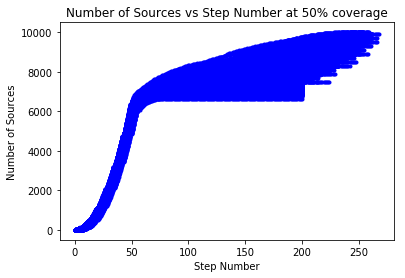

In [18]:
for i in range(repeat):
    plt.plot(range(len(main_source[str(i)])), main_source[str(i)], 'b.-')
plt.ylabel('Number of Sources')
plt.xlabel('Step Number')
plt.title('Number of Sources vs Step Number at 50% coverage')
plt.savefig('50_source.png', bbox_inches='tight')
plt.show()

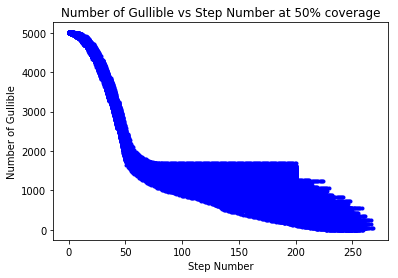

In [19]:
for i in range(repeat):
    plt.plot(range(len(main_gullible[str(i)])), main_gullible[str(i)], 'b.-')
plt.ylabel('Number of Gullible')
plt.xlabel('Step Number')
plt.title('Number of Gullible vs Step Number at 50% coverage')
plt.savefig('50_Gullible.png', bbox_inches='tight')
plt.show()

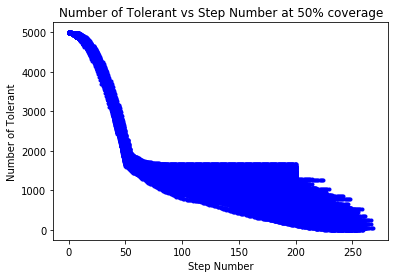

In [20]:
for i in range(repeat):
    plt.plot(range(len(main_tolerant[str(i)])), main_tolerant[str(i)], 'b.-')
plt.ylabel('Number of Tolerant')
plt.xlabel('Step Number')
plt.title('Number of Tolerant vs Step Number at 50% coverage')
plt.savefig('50_tolerant.png', bbox_inches='tight')
plt.show()